# Import

In [4]:
import sys
print(sys.executable)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\python.exe


In [5]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import matplotlib.patches as patches
import os
import glob
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryJaccardIndex
from sklearn.model_selection import train_test_split
import itertools
import cv2
import json
import base64
import zlib
import io
import random

In [3]:
# model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True).eval()
# model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
model = models.segmentation.deeplabv3_mobilenet_v3_large(weights=models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1)

# Run

In [4]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU count: {torch.cuda.device_count()}")
else:
    print("WARNING: CUDA not available, using CPU only!")

PyTorch version: 2.10.0.dev20251106+cu128
CUDA available: True
CUDA version: 12.8
GPU device: NVIDIA GeForce RTX 5070 Ti
GPU count: 1


In [32]:
input_image = Image.open('test_image/blackpig1.jpg')
preprocess = transforms.Compose([
    transforms.Resize(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)['out'][0]
mask = output.argmax(0).byte().cpu().numpy()

binary_mask = (mask != 0).astype(np.uint8)

labeled, num_features = ndimage.label(binary_mask)

sizes = ndimage.sum(binary_mask, labeled, range(1, num_features + 1))
largest_label = (sizes.argmax() + 1)
pig_mask = (labeled == largest_label)

coords = np.column_stack(np.where(pig_mask))

min_row, min_col = coords.min(axis=0)
max_row, max_col = coords.max(axis=0)

pig_length_pixels = max(max_row - min_row, max_col - min_col)
print("Pig length (in pixels):", pig_length_pixels)

fig, ax = plt.subplots()
ax.imshow(pig_mask, cmap='gray')
#rect = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
#linewidth=2, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

center_row = (min_row + max_row) // 3
ref_length = 30
ref_start_col = min_col + (max_col - min_col - ref_length) // 2
ref_end_col = ref_start_col + ref_length
ax.plot([ref_start_col, ref_end_col], [center_row, center_row], color='red', linewidth=2, label=f'Reference Line ({ref_length} px)')

plt.title("Pig with Reference Line (short, x-axis)")
plt.axis('off')
plt.show()

reference_length_cm = 50
pixels_per_cm = ref_length / reference_length_cm
pig_length_pixels = max(max_row - min_row, max_col - min_col)
pig_length_cm = pig_length_pixels / pixels_per_cm
print(f"Pig length: {pig_length_pixels:.2f} pixels ≈ {pig_length_cm:.2f} cm (using reference line)")

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

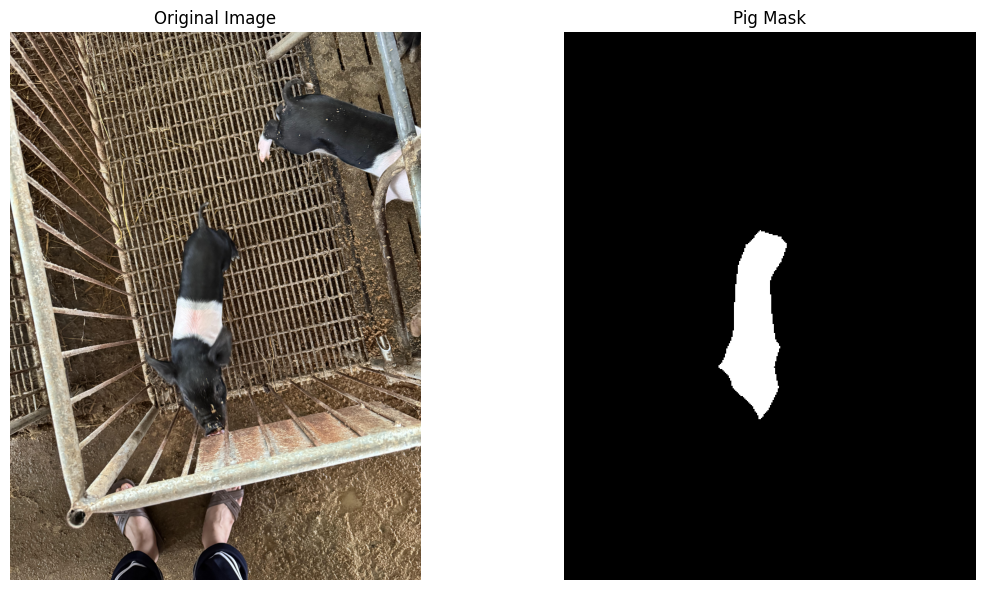

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(input_image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(pig_mask, cmap='gray')
axes[1].set_title('Pig Mask')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [5]:
def decode_supervisely_bitmap_proper(annotation_data):
    """
    Properly decode Supervisely bitmap mask from annotation data
    Supervisely stores bitmap data as compressed PNG-like format
    """
    img_height = annotation_data['size']['height']
    img_width = annotation_data['size']['width']
    
    # Create empty mask
    full_mask = np.zeros((img_height, img_width), dtype=np.uint8)
    
    for obj in annotation_data.get('objects', []):
        if obj.get('geometryType') == 'bitmap' and 'bitmap' in obj:
            bitmap_data = obj['bitmap']
            
            # Get the encoded bitmap data and origin
            encoded_data = bitmap_data['data']
            origin = bitmap_data['origin']  # [x, y] coordinates
            
            try:
                # Decode base64 and decompress
                compressed_data = base64.b64decode(encoded_data)
                decompressed_data = zlib.decompress(compressed_data)
                
                print(f"Decompressed data length: {len(decompressed_data)}")
                print(f"Origin: {origin}")
                
                # Supervisely bitmap data is typically stored as PNG-like format
                # Try to decode as image data first
                try:
                    # Try to load as image bytes
                    img_bytes = io.BytesIO(decompressed_data)
                    bitmap_img = Image.open(img_bytes)
                    bitmap_array = np.array(bitmap_img)
                    
                    # Convert to binary mask if needed
                    if len(bitmap_array.shape) > 2:
                        # Convert to grayscale if RGB
                        bitmap_array = np.mean(bitmap_array, axis=2)
                    
                    # Normalize to 0-255
                    bitmap_array = (bitmap_array > 0).astype(np.uint8) * 255
                    
                except:
                    # If that fails, try other decoding methods
                    # Supervisely sometimes stores data as raw bytes with width/height info
                    
                    # Try to find dimensions from the remaining space
                    remaining_width = img_width - origin[0]
                    remaining_height = img_height - origin[1]
                    
                    # Check if it's a simple bitmap (1 bit per pixel, packed)
                    expected_bits = remaining_width * remaining_height
                    expected_bytes = (expected_bits + 7) // 8  # Round up to nearest byte
                    
                    if len(decompressed_data) == expected_bytes:
                        # Unpack bits
                        bits = np.unpackbits(np.frombuffer(decompressed_data, dtype=np.uint8))
                        bitmap_array = bits[:expected_bits].reshape((remaining_height, remaining_width)) * 255
                    else:
                        # Try interpreting as bytes directly
                        mask_1d = np.frombuffer(decompressed_data, dtype=np.uint8)
                        
                        # Find best fitting dimensions
                        possible_dims = []
                        for w in range(1, min(remaining_width + 1, len(mask_1d) + 1)):
                            if len(mask_1d) % w == 0:
                                h = len(mask_1d) // w
                                if h <= remaining_height and w <= remaining_width:
                                    possible_dims.append((h, w))
                        
                        if possible_dims:
                            # Choose the most square-like dimensions
                            h, w = min(possible_dims, key=lambda x: abs(x[0] - x[1]))
                            bitmap_array = mask_1d.reshape((h, w))
                            # Threshold to binary
                            bitmap_array = (bitmap_array > 0).astype(np.uint8) * 255
                        else:
                            print(f"Could not determine bitmap dimensions")
                            continue
                
                print(f"Bitmap shape: {bitmap_array.shape}")
                print(f"Bitmap unique values: {np.unique(bitmap_array)}")
                
                # Place the bitmap in the full mask
                end_y = min(origin[1] + bitmap_array.shape[0], img_height)
                end_x = min(origin[0] + bitmap_array.shape[1], img_width)
                
                actual_h = end_y - origin[1]
                actual_w = end_x - origin[0]
                
                # Resize bitmap if necessary
                if bitmap_array.shape != (actual_h, actual_w):
                    bitmap_pil = Image.fromarray(bitmap_array)
                    bitmap_pil = bitmap_pil.resize((actual_w, actual_h), Image.NEAREST)
                    bitmap_array = np.array(bitmap_pil)
                
                full_mask[origin[1]:end_y, origin[0]:end_x] = bitmap_array
                
            except Exception as e:
                print(f"Error decoding bitmap: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    return full_mask

# Load and decode the annotation
# json_path = r"supervisely/dataset/ann/blackpig1crop.jpg.json"
# with open(json_path, 'r') as f:
#     annotation_data = json.load(f)

# print("Annotation info:")
# print(f"Image size: {annotation_data['size']}")
# print(f"Number of objects: {len(annotation_data.get('objects', []))}")

# # Decode the bitmap mask
# mask = decode_supervisely_bitmap_proper(annotation_data)

# print(f"\nFinal mask shape: {mask.shape}")
# print(f"Final mask unique values: {np.unique(mask)}")
# print(f"Non-zero pixels: {np.sum(mask > 0)}")

# # Visualize the mask
# plt.figure(figsize=(12, 8))
# plt.subplot(1, 2, 1)
# plt.imshow(mask, cmap='gray')
# plt.title('Decoded Supervisely Bitmap Mask')
# plt.axis('off')

# # Show mask as binary
# plt.subplot(1, 2, 2)
# binary_mask = (mask > 0).astype(np.uint8)
# plt.imshow(binary_mask, cmap='gray')
# plt.title('Binary Mask')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

In [6]:
def simple_augmentations(image, mask):
    """
    Simple augmentations using only OpenCV and NumPy
    """
    augmented_pairs = []
    
    # Original
    augmented_pairs.append((image.copy(), mask.copy()))
    
    # Most common real-world issues:
    
    # 1. Motion blur (very common in mobile photos)
    kernel_size = random.choice([11, 13, 15])
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[kernel_size//2, :] = np.ones(kernel_size) / kernel_size
    img_blur = cv2.filter2D(image, -1, kernel)
    augmented_pairs.append((img_blur, mask.copy()))
    
    # 2. Lighting variations (indoor vs outdoor)
    alpha = random.uniform(0.6, 1.4)  # Contrast
    beta = random.randint(-40, 40)    # Brightness
    img_light = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    augmented_pairs.append((img_light, mask.copy()))
    
    # 3. Color shifts (different camera white balance)
    b, g, r = cv2.split(image)
    r_shift = random.randint(-15, 15)
    b_shift = random.randint(-15, 15)
    r = np.clip(r.astype(np.int16) + r_shift, 0, 255).astype(np.uint8)
    b = np.clip(b.astype(np.int16) + b_shift, 0, 255).astype(np.uint8)
    img_color = cv2.merge([b, g, r])
    augmented_pairs.append((img_color, mask.copy()))
    
    # 4. Noise (low-light conditions)
    noise = np.random.normal(0, random.randint(10, 25), image.shape).astype(np.uint8)
    img_noise = cv2.add(image, noise)
    augmented_pairs.append((img_noise, mask.copy()))
    
    # 5. Partial occlusion (fingers, objects in view)
    h, w = image.shape[:2]
    img_occ = image.copy()
    mask_occ = mask.copy()
    
    # Add 1-2 small occlusions
    for _ in range(random.randint(1, 2)):
        occ_size = random.randint(w//15, w//8)
        x = random.randint(0, w - occ_size)
        y = random.randint(0, h - occ_size)
        cv2.rectangle(img_occ, (x, y), (x + occ_size, y + occ_size), 
                     (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), -1)
        cv2.rectangle(mask_occ, (x, y), (x + occ_size, y + occ_size), 0, -1)
    
    augmented_pairs.append((img_occ, mask_occ))
    
    return augmented_pairs

def create_augmented_dataset_simple(dataset_path, output_path, num_augmentations=5):
    """
    Apply simple data augmentation without albumentations
    """
    img_dir = os.path.join(dataset_path, "img")
    ann_dir = os.path.join(dataset_path, "ann")
    
    # Debug: Check what files actually exist
    print(f"Checking directories:")
    print(f"Image directory: {img_dir}")
    print(f"Annotation directory: {ann_dir}")
    
    if os.path.exists(img_dir):
        img_files = os.listdir(img_dir)
        print(f"Image files found: {img_files}")
    else:
        print(f"Image directory does not exist: {img_dir}")
        return
    
    if os.path.exists(ann_dir):
        ann_files = os.listdir(ann_dir)
        print(f"Annotation files found: {ann_files}")
    else:
        print(f"Annotation directory does not exist: {ann_dir}")
        return
    
    # Create output directories
    output_img_dir = os.path.join(output_path, "img")
    output_ann_dir = os.path.join(output_path, "ann")
    output_mask_dir = os.path.join(output_path, "masks")
    
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_ann_dir, exist_ok=True)
    os.makedirs(output_mask_dir, exist_ok=True)
    
    # Create a mapping of available image files (without extensions)
    available_images = {}
    for img_file in os.listdir(img_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            # Get base name without extension
            base_name = os.path.splitext(img_file)[0]
            available_images[base_name] = img_file
    
    print(f"Available image base names: {list(available_images.keys())}")
    
    # Process each annotation file
    processed_count = 0
    for json_file in os.listdir(ann_dir):
        if not json_file.endswith('.json'):
            continue
            
        # Get base name from JSON file (remove .json extension)
        base_name = json_file.replace('.json', '')
        print(f"Looking for image matching: '{base_name}'")
        
        # Look for exact match first
        img_file = available_images.get(base_name)
        
        # If no exact match, try fuzzy matching
        if img_file is None:
            # Try removing common suffixes that might be added to JSON files
            for suffix in ['.jpg', '.jpeg', '.png']:
                if base_name.endswith(suffix):
                    clean_base = base_name[:-len(suffix)]
                    img_file = available_images.get(clean_base)
                    if img_file:
                        break
        
        if img_file is None:
            print(f"No corresponding image found for {json_file}")
            print(f"  Tried base name: '{base_name}'")
            continue
            
        print(f"Processing: {img_file} with {json_file}")
        
        # Load image and annotation
        img_path = os.path.join(img_dir, img_file)
        json_path = os.path.join(ann_dir, json_file)
        
        try:
            # Load image
            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to load image: {img_path}")
                continue
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load and decode mask
            with open(json_path, 'r') as f:
                annotation_data = json.load(f)
            
            mask = decode_supervisely_bitmap_proper(annotation_data)
            mask_binary = (mask > 0).astype(np.uint8)
            
            # Generate augmentations
            augmented_pairs = simple_augmentations(image, mask_binary)
            
            # Save augmented versions
            for i, (aug_image, aug_mask) in enumerate(augmented_pairs[:num_augmentations + 1]):
                if i == 0:
                    # Original
                    prefix = "original"
                else:
                    # Augmented
                    prefix = f"aug_{i-1}"
                
                # Save image
                img_name = f"{prefix}_{img_file}"
                cv2.imwrite(os.path.join(output_img_dir, img_name), 
                           cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
                
                # Save mask
                mask_name = f"{prefix}_{os.path.splitext(base_name)[0]}_mask.png"
                cv2.imwrite(os.path.join(output_mask_dir, mask_name), 
                           aug_mask * 255)
                
                # Save annotation for original only
                if i == 0:
                    ann_name = f"{prefix}_{json_file}"
                    with open(os.path.join(output_ann_dir, ann_name), 'w') as f:
                        json.dump(annotation_data, f)
                
                print(f"  Generated {prefix}")
            
            processed_count += 1
                
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"Successfully processed {processed_count} image-annotation pairs")
    print(f"Augmented dataset created in: {output_path}")

# Use the simple version
dataset_path = "supervisely/dataset"
output_path = "supervisely/augmented_dataset"

create_augmented_dataset_simple(dataset_path, output_path, num_augmentations=4)

Checking directories:
Image directory: supervisely/dataset\img
Annotation directory: supervisely/dataset\ann
Image files found: ['2246b75a-6673-45b7-8d50-fc68a1daba20.png', '3.jpg', '43777abf-3373-4d53-80b2-ddcd06745714.png', '82988.jpg', '82989.jpg', '82990.jpg', '82991.jpg', '82992.jpg', '82993.jpg', '82996.jpg', '82997.jpg', '82998.jpg', '82999.jpg', '83000.jpg', '83001.jpg', '83002.jpg', '83003.jpg', '83006.jpg', '83007.jpg', '83008.jpg', '83009.jpg', '83010.jpg', '83011.jpg', '83012.jpg', '83013.jpg', '83014.jpg', 'blackpig1.png', 'blackpig1crop.jpg', 'IMG_0366.jpeg', 'Whisk_0bd47403e2c5b1e8995421c54b59651ddr.jpeg', 'Whisk_0cty4e2nzetzjfjztqjnxiwllvwm00cnxmjztat.jpeg', 'Whisk_0cty4e2nzetzjfjztqjnxiwllvwm00cnxmjztat_01.jpeg', 'Whisk_0d436dde9644c4784a843f8915858d9ddr.jpeg', 'Whisk_0edn5m2n1mzykn2ytydzziwl0aty00cozqgztej.jpeg', 'Whisk_0i2ylnjzjdzmmrtmtgtmhltl5azn00cz1mdmtij.jpeg', 'Whisk_0ktzjnmmwmjnlrmytkdo5iwl0i2m00im4emytkt.jpeg', 'Whisk_0mdzhhtmyijz1ktztuwn4gtl5u2m00iz4mjmted.jp

In [5]:
def load_image_mask_pairs(image_dir, mask_dir):
    """Loads image and mask file paths from specified directories."""
    image_paths = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_paths.extend(glob.glob(os.path.join(image_dir, ext)))
    mask_paths = glob.glob(os.path.join(mask_dir, '*.png'))

    image_paths.sort()
    mask_paths.sort()

    if len(image_paths) != len(mask_paths):
        raise ValueError("Number of images and masks do not match!")

    return list(zip(image_paths, mask_paths))

image_directory = 'supervisely/augmented_dataset/img'
mask_directory = 'supervisely/augmented_dataset/masks'

try:
    dataset_pairs = load_image_mask_pairs(image_directory, mask_directory)
    print(f"Found {len(dataset_pairs)} image-mask pairs.")
    # You can inspect the first few pairs
    # print(dataset_pairs[:5])
except ValueError as e:
    print(f"Error loading dataset: {e}")

Found 1200 image-mask pairs.


In [6]:
# Define the loss function
# For binary segmentation (pig body vs. background), Binary Cross-Entropy is suitable
criterion = nn.BCEWithLogitsLoss() # Combines Sigmoid and BCELoss

# Define the optimizer
# Adam is a good general-purpose optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# You can also define other training parameters like learning rate scheduler, number of epochs, etc.
# For example, a learning rate scheduler can reduce the learning rate during training
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Training setup complete: Loss function and optimizer defined.")

Training setup complete: Loss function and optimizer defined.


In [7]:
class PigSegmentationDataset(Dataset):
    def __init__(self, image_mask_pairs, image_transform=None, mask_transform=None):
        self.image_mask_pairs = image_mask_pairs
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]
        image = Image.open(img_path).convert("RGB") # Ensure image is RGB
        mask = Image.open(mask_path).convert("L") # Convert mask to grayscale

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Define transformations
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)), # Resize images to a fixed size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # Resize masks using nearest neighbor interpolation
    transforms.ToTensor(),
])

# Create the dataset
segmentation_dataset = PigSegmentationDataset(dataset_pairs, image_transform=image_transforms, mask_transform=mask_transforms)

# Create a DataLoader (you can adjust batch_size and shuffle)
dataloader = DataLoader(segmentation_dataset, batch_size=4, shuffle=True)

print(f"Created dataset with {len(segmentation_dataset)} samples.")
# You can iterate through the dataloader to get batches of data
# for images, masks in dataloader:
#     print(images.shape, masks.shape)
#     break

Created dataset with 1200 samples.


In [8]:
# Load the pre-trained DeepLabV3 model with a ResNet101 backbone
# Using weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1 for pretrained weights
# model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
model = models.segmentation.deeplabv3_mobilenet_v3_large(weights=models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1)


# Replace the classifier to output 1 class (pig body)
# The original model outputs 21 classes (VOC dataset)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Modify the auxiliary classifier if present
# It has a different number of input channels than the main classifier
if model.aux_classifier is not None:
    model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))


print("DeepLabV3 model customized for 1 output class.")

DeepLabV3 model customized for 1 output class.


In [9]:

# Split into training and testing sets (e.g., 80% train, 20% test)
train_pairs, test_pairs = train_test_split(dataset_pairs, test_size=0.2, random_state=42)

# Split the testing set into validation and testing sets (e.g., 50% validation, 50% test)
val_pairs, test_pairs = train_test_split(test_pairs, test_size=0.5, random_state=42)

print(f"Number of training samples: {len(train_pairs)}")
print(f"Number of validation samples: {len(val_pairs)}")
print(f"Number of testing samples: {len(test_pairs)}")

Number of training samples: 960
Number of validation samples: 120
Number of testing samples: 120


In [10]:
# Create the dataset instances
train_dataset = PigSegmentationDataset(train_pairs, image_transform=image_transforms, mask_transform=mask_transforms)
val_dataset = PigSegmentationDataset(val_pairs, image_transform=image_transforms, mask_transform=mask_transforms)
test_dataset = PigSegmentationDataset(test_pairs, image_transform=image_transforms, mask_transform=mask_transforms)

# Create the DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Created training dataset with {len(train_dataset)} samples and dataloader.")
print(f"Created validation dataset with {len(val_dataset)} samples and dataloader.")
print(f"Created testing dataset with {len(test_dataset)} samples and dataloader.")

Created training dataset with 960 samples and dataloader.
Created validation dataset with 120 samples and dataloader.
Created testing dataset with 120 samples and dataloader.


In [11]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
iou_metric = BinaryJaccardIndex().to(device)

print("IoU metric initialized.")

IoU metric initialized.


In [12]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Compute Capability: {torch.cuda.get_device_capability(0)}")
    
    # Test GPU computation
    try:
        x = torch.randn(1000, 1000).cuda()
        y = torch.randn(1000, 1000).cuda()
        z = torch.matmul(x, y)
        print("✓ GPU computation successful!")
        
        # Test a small segmentation model operation
        model = torch.nn.Conv2d(3, 64, 3, padding=1).cuda()
        test_input = torch.randn(1, 3, 256, 256).cuda()
        output = model(test_input)
        print(f"✓ GPU model forward pass successful! Output shape: {output.shape}")
        
    except Exception as e:
        print(f"✗ GPU error: {e}")
        import traceback
        traceback.print_exc()
else:
    print("WARNING: CUDA not available!")

PyTorch version: 2.10.0.dev20251106+cu128
CUDA available: True
CUDA version: 12.8
GPU device: NVIDIA GeForce RTX 5070 Ti
CUDA Compute Capability: (12, 0)
✓ GPU computation successful!
✓ GPU model forward pass successful! Output shape: torch.Size([1, 64, 256, 256])


In [15]:
def train_fn(num_epochs, model, train_dataloader, criterion, optimizer_class, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = optimizer_class(model.parameters(), lr=lr)

    print(f"Starting training on device: {device} with lr={lr} and optimizer={optimizer_class.__name__}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_dataloader: # Use train_dataloader
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            outputs = model(images)['out']
            loss = criterion(outputs, masks.float())

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    print("Training finished!")


# Define hyperparameter grid (adjust values as needed)
keys = ['num_epochs', 'optimizer', 'lr']
values = [
    [5, 10],  # num_epochs options
    [torch.optim.Adam, torch.optim.SGD],  # optimizer classes
    [1e-3, 1e-4]  # learning rates
]

print(f"Hyperparameter grid keys: {keys}")
print(f"Number of combinations: {len(list(itertools.product(*values)))}")

best_iou = -1
best_dice = -1
best_hyperparameters = None

for combination in itertools.product(*values):
    hyperparameters = dict(zip(keys, combination))
    print(f"Training with hyperparameters: {hyperparameters}")

    # Re-initialize the model for each training run
    model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
    model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    if model.aux_classifier is not None:
        model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))


    # Train the model with the current hyperparameters using the train_dataloader
    train_fn(
        num_epochs=hyperparameters['num_epochs'],
        model=model,
        train_dataloader=train_dataloader, # Pass train_dataloader
        criterion=criterion,
        optimizer_class=hyperparameters['optimizer'],
        lr=hyperparameters['lr']
    )

    # Evaluate the model on the validation set using the val_dataloader
    model.eval()
    iou_metric.reset()
    total_dice = 0.0
    num_batches = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    iou_metric.to(device)


    with torch.no_grad():
        for images, masks in val_dataloader: # Use val_dataloader for evaluation
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)['out']
            probabilities = torch.sigmoid(outputs)
            predicted_masks = (probabilities > 0.5).squeeze(1)

            masks = masks.squeeze(1).bool()

            batch_iou = iou_metric(predicted_masks.int(), masks.int())

            intersection = (predicted_masks & masks).sum()
            union = (predicted_masks | masks).sum()
            batch_dice = (2. * intersection) / (union + intersection) if (union + intersection) > 0 else 1.0

            total_dice += batch_dice.item()
            num_batches += 1

    # Protect against division by zero if no batches were evaluated
    average_iou = iou_metric.compute().item() if num_batches > 0 else 0.0
    average_dice = total_dice / num_batches if num_batches > 0 else 0.0

    print(f"Evaluation results - IoU: {average_iou:.4f}, Dice: {average_dice:.4f}")

    if average_iou > best_iou:
        best_iou = average_iou
        best_dice = average_dice
        best_hyperparameters = hyperparameters

print("\nGrid search finished.")
print("Best Hyperparameters:", best_hyperparameters)
print(f"Best IoU: {best_iou:.4f}")
print(f"Best Dice Score: {best_dice:.4f}")


Hyperparameter grid keys: ['num_epochs', 'optimizer', 'lr']
Number of combinations: 8
Training with hyperparameters: {'num_epochs': 5, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Starting training on device: cuda with lr=0.001 and optimizer=Adam
Epoch [1/5], Loss: 0.1145
Epoch [2/5], Loss: 0.0429
Epoch [3/5], Loss: 0.0350
Epoch [4/5], Loss: 0.0246
Epoch [5/5], Loss: 0.0255
Training finished!
Evaluation results - IoU: 0.8100, Dice: 0.9036
Training with hyperparameters: {'num_epochs': 5, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0001}
Starting training on device: cuda with lr=0.0001 and optimizer=Adam
Epoch [1/5], Loss: 0.2657
Epoch [2/5], Loss: 0.1008
Epoch [3/5], Loss: 0.0583
Epoch [4/5], Loss: 0.0377
Epoch [5/5], Loss: 0.0282
Training finished!
Evaluation results - IoU: 0.7433, Dice: 0.8723
Training with hyperparameters: {'num_epochs': 5, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.001}
Starting training on device: cuda with lr=0.001 and optimizer=SG

In [16]:
# Get the best parameter and train again to save model

print("\nGrid search finished.")
print("Best Hyperparameters:", best_hyperparameters)
print(f"Best IoU: {best_iou:.4f}")
print(f"Best Dice Score: {best_dice:.4f}")

# Save the best model
if best_hyperparameters is not None:
    print("\n" + "="*60)
    print("Retraining and saving the best model...")
    print(f"Best hyperparameters: {best_hyperparameters}")
    print("="*60)
    
    # Re-initialize the model with the best architecture
    best_model = models.segmentation.deeplabv3_resnet101(
        weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
    )
    best_model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    if best_model.aux_classifier is not None:
        best_model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    
    # Retrain with best hyperparameters
    train_fn(
        num_epochs=best_hyperparameters['num_epochs'],
        model=best_model,
        train_dataloader=train_dataloader,
        criterion=criterion,
        optimizer_class=best_hyperparameters['optimizer'],
        lr=best_hyperparameters['lr']
    )
    
    # Create directory for saved models
    save_dir = 'saved_models'
    os.makedirs(save_dir, exist_ok=True)
    
    model_path = os.path.join(save_dir, 'best_pig_segmentation_model.pth')
    checkpoint_path = os.path.join(save_dir, 'best_pig_segmentation_checkpoint.pth')
    
    # Save model state dict
    torch.save(best_model.state_dict(), model_path)
    print(f"\n✓ Best model saved to: {model_path}")
    
    # Save complete checkpoint with hyperparameters and metrics
    checkpoint = {
        'model_state_dict': best_model.state_dict(),
        'hyperparameters': best_hyperparameters,
        'best_iou': best_iou,
        'best_dice': best_dice,
        'epoch': best_hyperparameters['num_epochs']
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✓ Complete checkpoint saved to: {checkpoint_path}")
    
    print("\n" + "="*60)
    print("MODEL SAVED SUCCESSFULLY!")
    print(f"Location: {os.path.abspath(save_dir)}")
    print("="*60)
    
    print("\nTo load this model later, use:")
    print("""
# Load the model architecture
model = models.segmentation.deeplabv3_resnet101(weights=None)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
if model.aux_classifier is not None:
    model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Load the saved weights
model.load_state_dict(torch.load('saved_models/best_pig_segmentation_model.pth'))
model.eval()

# Or load the complete checkpoint
checkpoint = torch.load('saved_models/best_pig_segmentation_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model with IoU: {checkpoint['best_iou']:.4f}")
    """)
else:
    print("\nNo best hyperparameters found. Training may have failed.")


Grid search finished.
Best Hyperparameters: {'num_epochs': 10, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Best IoU: 0.9296
Best Dice Score: 0.9614

Retraining and saving the best model...
Best hyperparameters: {'num_epochs': 10, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Starting training on device: cuda with lr=0.001 and optimizer=Adam
Epoch [1/10], Loss: 0.1116
Epoch [2/10], Loss: 0.0519
Epoch [3/10], Loss: 0.0316
Epoch [4/10], Loss: 0.0257
Epoch [5/10], Loss: 0.0211
Epoch [6/10], Loss: 0.0189
Epoch [7/10], Loss: 0.0138
Epoch [8/10], Loss: 0.0148
Epoch [9/10], Loss: 0.0170
Epoch [10/10], Loss: 0.0127
Training finished!

✓ Best model saved to: saved_models\best_pig_segmentation_model.pth
✓ Complete checkpoint saved to: saved_models\best_pig_segmentation_checkpoint.pth

MODEL SAVED SUCCESSFULLY!
Location: d:\Wave_CMKL\Year2_term1\URD-2_BlackPigProject\pig_segmentation\segment\saved_models

To load this model later, use:

# Load the model architecture
mo

Loading the best saved model...
Model loaded from saved_models/best_pig_segmentation_model.pth


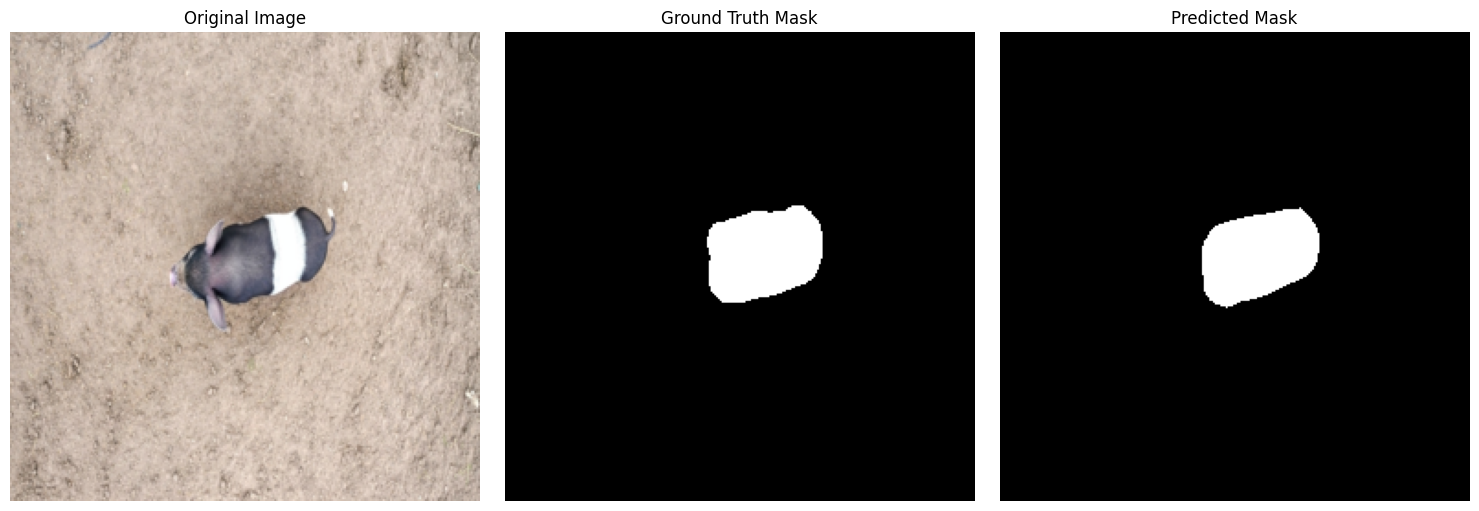

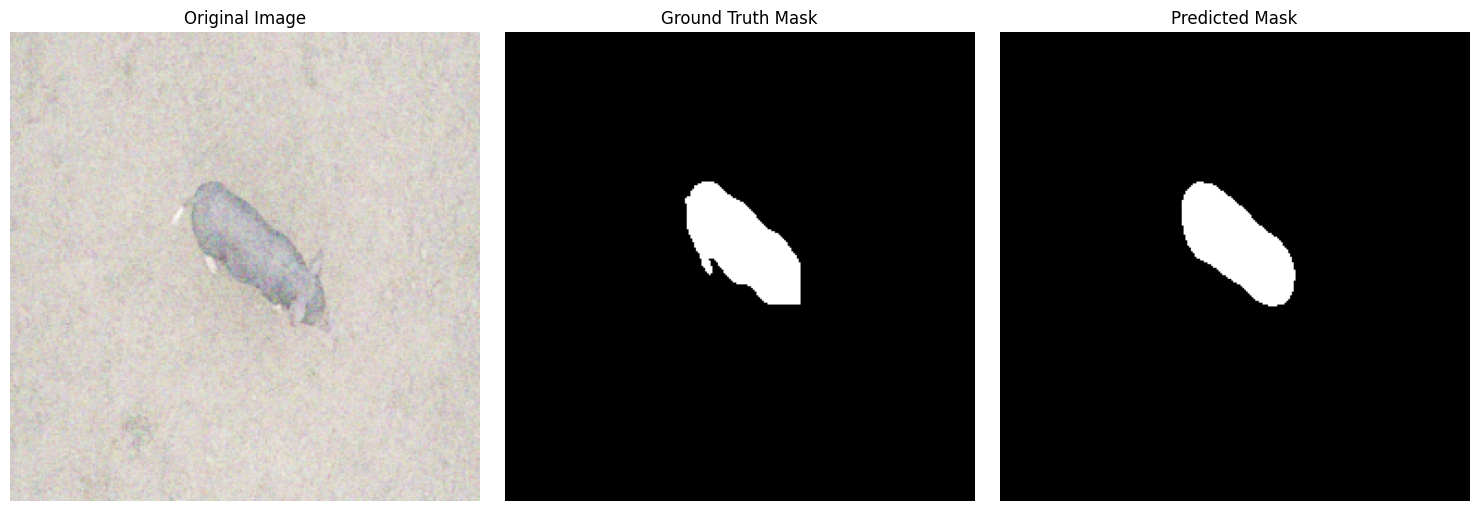

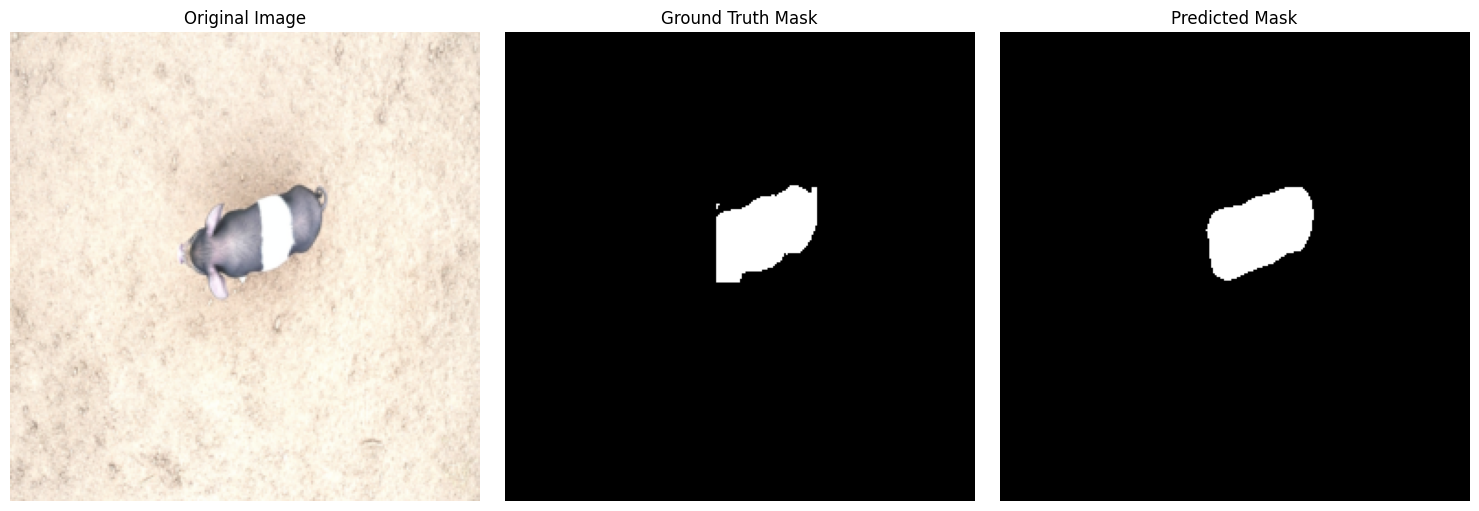

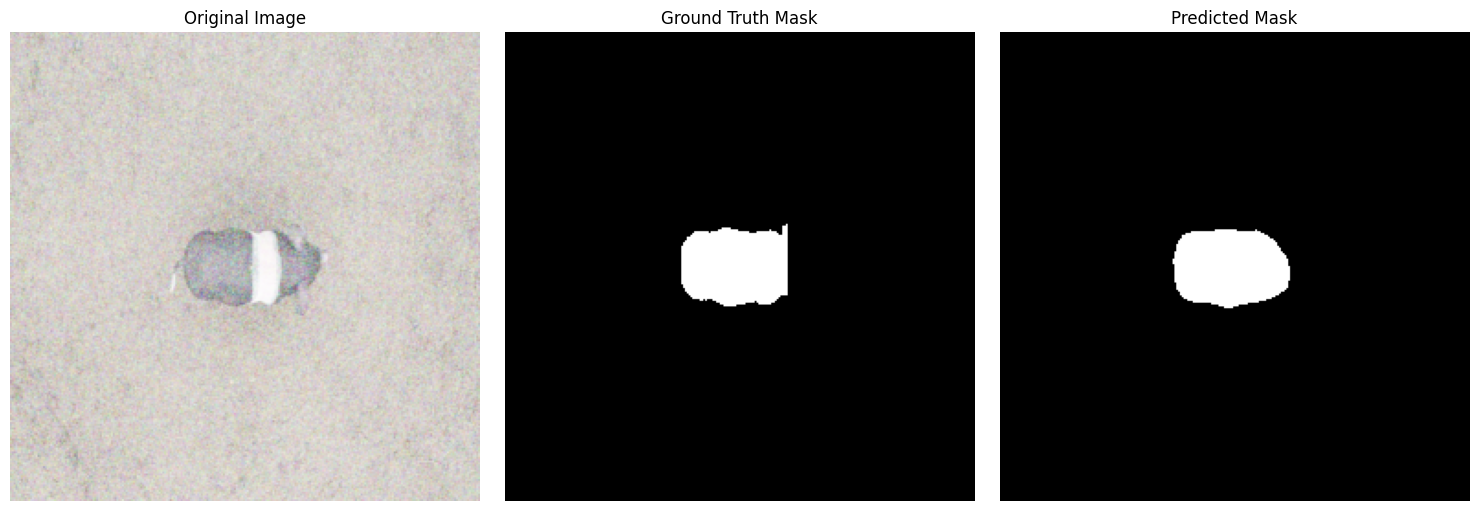

In [17]:
# test the model with samples

# Load the best trained model
print("Loading the best saved model...")
best_model = models.segmentation.deeplabv3_resnet101(
    weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
)
best_model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
if best_model.aux_classifier is not None:
    best_model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Load the saved weights
model_path = 'saved_models/best_pig_segmentation_model.pth'
best_model.load_state_dict(torch.load(model_path))
print(f"Model loaded from {model_path}")

# Get a batch of images and masks from the dataloader
images, masks = next(iter(dataloader))

# Move tensors to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
best_model.eval()

images = images.to(device)
masks = masks.to(device)

# Get model predictions
with torch.no_grad():
    outputs = best_model(images)['out']

# Apply sigmoid and threshold to get binary masks
probabilities = torch.sigmoid(outputs)
predicted_masks = (probabilities > 0.5).squeeze(1).cpu().numpy()

# Move original images and ground truth masks back to CPU for plotting
images = images.cpu().permute(0, 2, 3, 1).numpy()
masks = masks.cpu().squeeze(1).numpy()

# Denormalize images for better visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images * std + mean
images = np.clip(images, 0, 1)

# Visualize the results
for i in range(images.shape[0]):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(images[i])
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground Truth Mask
    axes[1].imshow(masks[i], cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Predicted Mask
    axes[2].imshow(predicted_masks[i], cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

Loading the best saved model...
Model loaded from saved_models/best_pig_segmentation_model.pth
Showing 4 random test images...


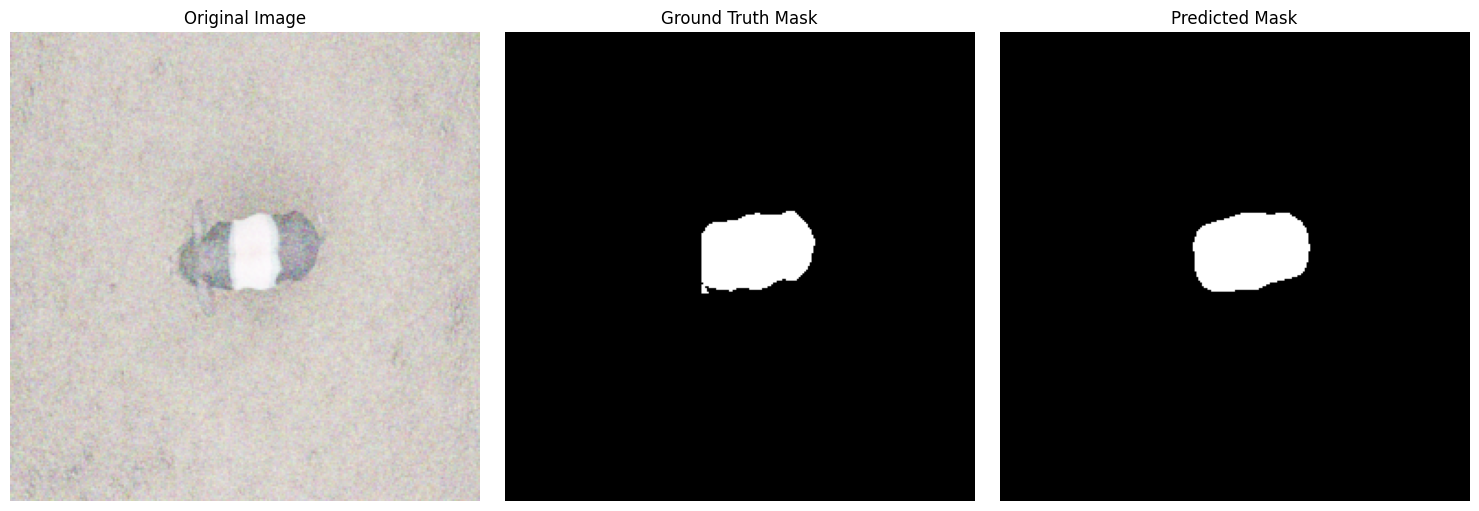

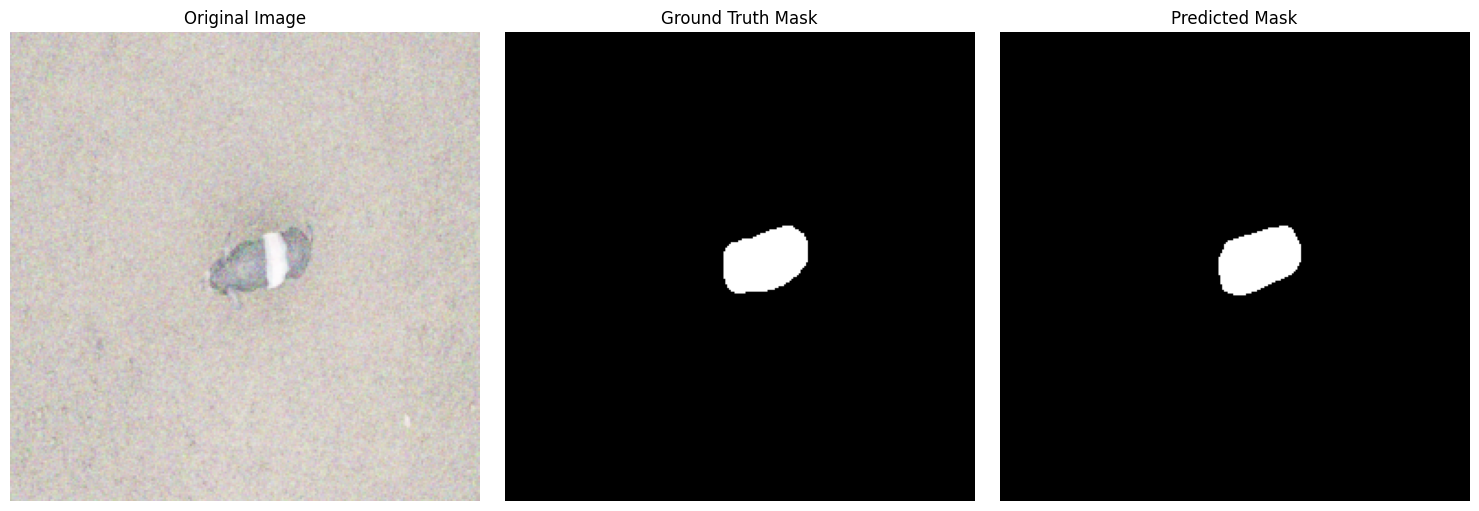

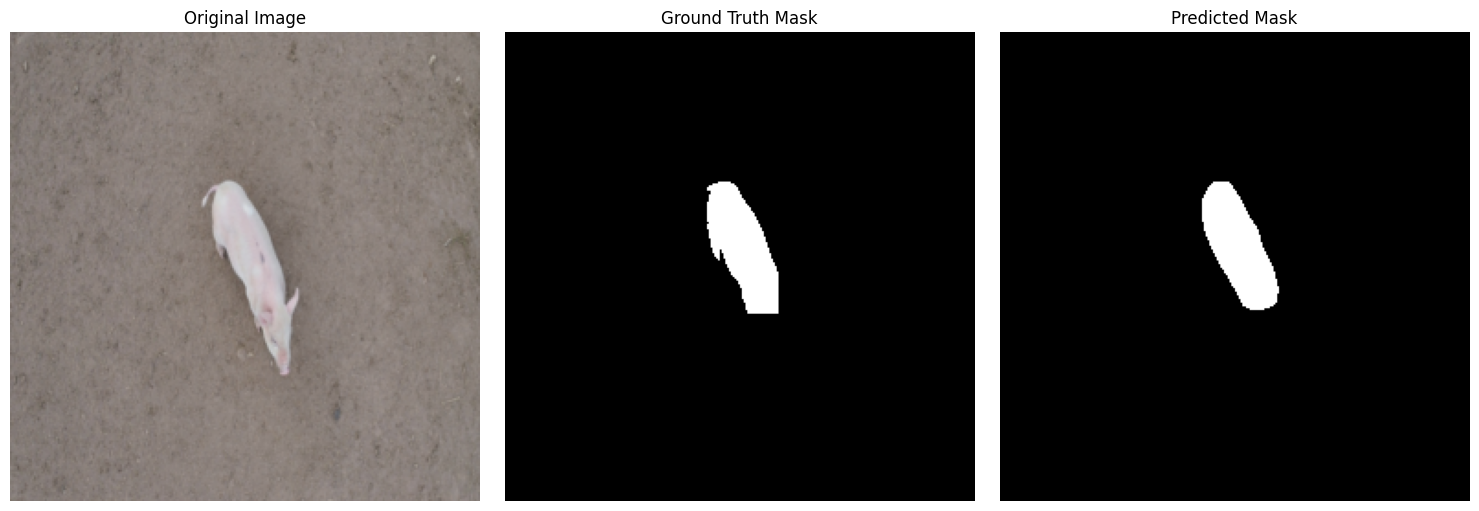

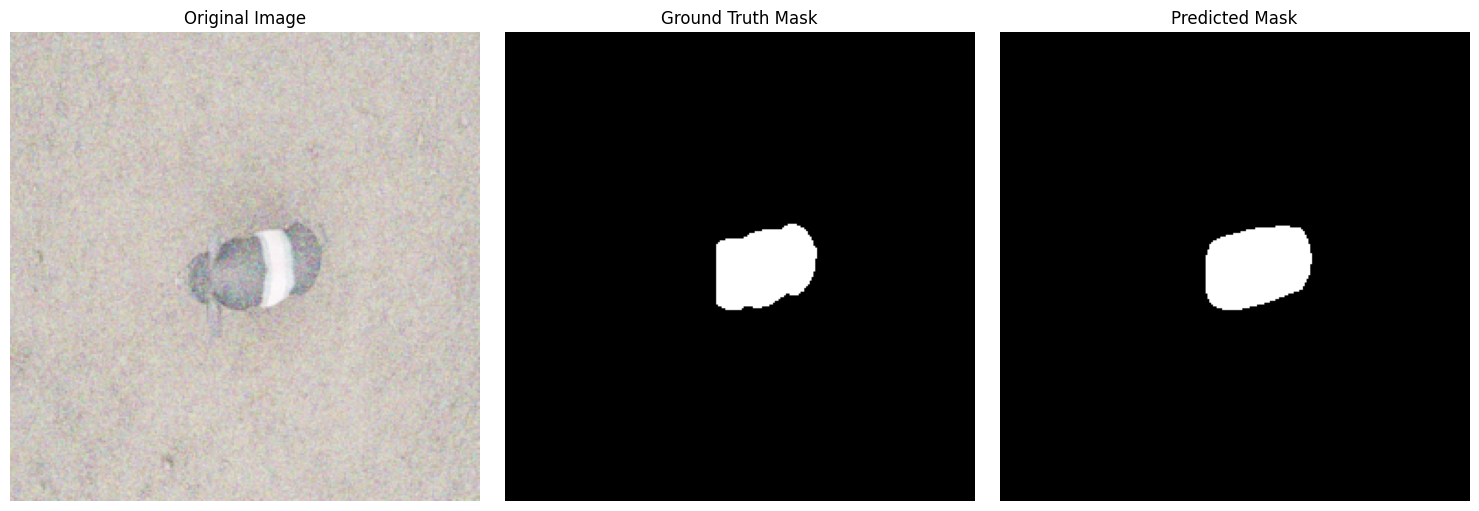

In [18]:
# random 5 images from test set to test the model
import random

# Load the best trained model
print("Loading the best saved model...")
best_model = models.segmentation.deeplabv3_resnet101(
    weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
)
best_model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
if best_model.aux_classifier is not None:
    best_model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Load the saved weights
model_path = 'saved_models/best_pig_segmentation_model.pth'
best_model.load_state_dict(torch.load(model_path))
print(f"Model loaded from {model_path}")

# Create a new dataloader with shuffle=True to get random samples each time
test_dataloader_random = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Get a random batch of images and masks from the TEST dataloader
images, masks = next(iter(test_dataloader_random))

# Move tensors to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
best_model.eval()

images = images.to(device)
masks = masks.to(device)

# Get model predictions
with torch.no_grad():
    outputs = best_model(images)['out']

# Apply sigmoid and threshold to get binary masks
probabilities = torch.sigmoid(outputs)
predicted_masks = (probabilities > 0.5).squeeze(1).cpu().numpy()

# Move original images and ground truth masks back to CPU for plotting
images = images.cpu().permute(0, 2, 3, 1).numpy()
masks = masks.cpu().squeeze(1).numpy()

# Denormalize images for better visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images * std + mean
images = np.clip(images, 0, 1)

# Visualize the results
print(f"Showing {images.shape[0]} random test images...")
for i in range(images.shape[0]):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(images[i])
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground Truth Mask
    axes[1].imshow(masks[i], cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Predicted Mask
    axes[2].imshow(predicted_masks[i], cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

Loading the best saved model...
Model loaded from saved_models/best_pig_segmentation_model.pth
Found 4 images in 'real_image'. Processing...


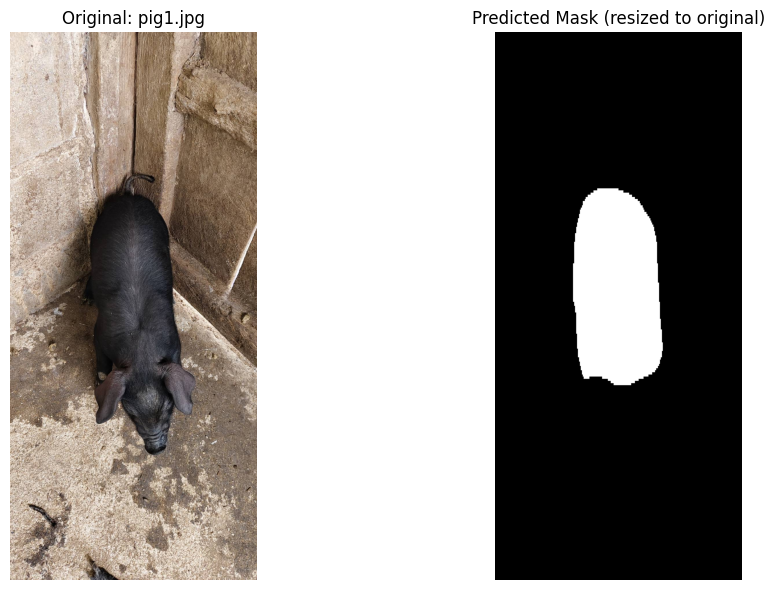

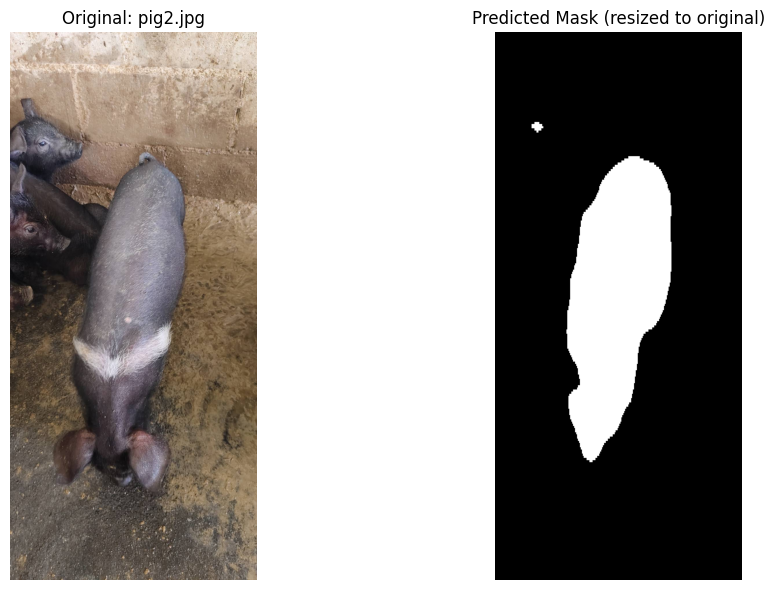

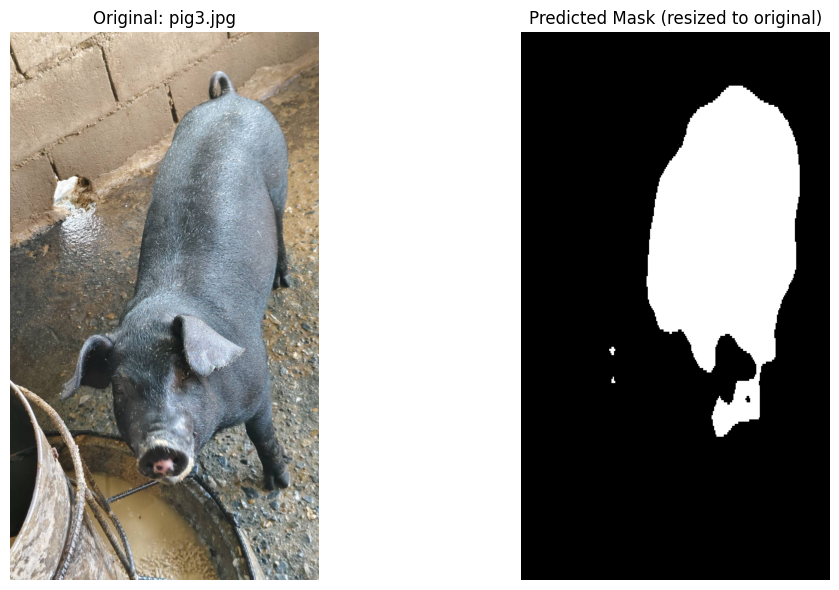

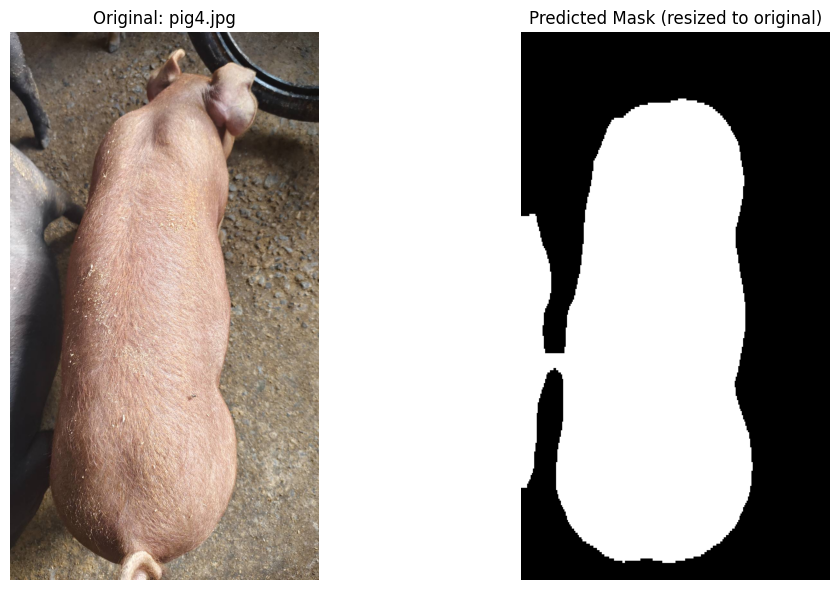

In [20]:
# Loop through images in folder 'real_image' and run prediction for each
print("Loading the best saved model...")
best_model = models.segmentation.deeplabv3_resnet101(
    weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
)
best_model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
if best_model.aux_classifier is not None:
    best_model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

model_path = 'saved_models/best_pig_segmentation_model.pth'
best_model.load_state_dict(torch.load(model_path))
print(f"Model loaded from {model_path}")

# use CPU for prediction (change to cuda if needed)
device = torch.device('cpu')
best_model.to(device)
best_model.eval()

# Collect image paths
image_dir = 'real_image'
image_paths = []
for ext in ('*.png', '*.jpg', '*.jpeg'):
    image_paths.extend(glob.glob(os.path.join(image_dir, ext)))
image_paths.sort()

if not image_paths:
    print(f"No images found in '{image_dir}'.")
else:
    print(f"Found {len(image_paths)} images in '{image_dir}'. Processing...")

for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    orig_w, orig_h = img.size  # PIL: (width, height)

    input_tensor = image_transforms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = best_model(input_tensor)['out']

    probabilities = torch.sigmoid(output)
    predicted_mask = (probabilities > 0.5).squeeze(0).squeeze(0).cpu().numpy().astype(np.uint8)  # 0/1 shape (H_res, W_res)

    # Resize predicted mask back to original image size using nearest neighbor
    mask_pil = Image.fromarray((predicted_mask * 255).astype(np.uint8))
    mask_resized_pil = mask_pil.resize((orig_w, orig_h), resample=Image.NEAREST)
    mask_resized = np.array(mask_resized_pil)  # 0-255

    # Convert to binary for display
    mask_resized_bin = (mask_resized > 127).astype(np.uint8)

    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img)
    axes[0].set_title(f'Original: {os.path.basename(img_path)}')
    axes[0].axis('off')

    axes[1].imshow(mask_resized_bin, cmap='gray')
    axes[1].set_title('Predicted Mask (resized to original)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


Convert model to pytorchlite

In [6]:
import torch
from torchvision import models
from torch.utils.mobile_optimizer import optimize_for_mobile

# --- Step 1: Re-create your model architecture ---
# IMPORTANT: Use pretrained weights to get the full architecture including aux_classifier
model = models.segmentation.deeplabv3_resnet101(
    weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
)

# Restore the modified classifier head for 1 class
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
if model.aux_classifier is not None:
    model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# --- Step 2: Load your saved .pth weights ---
model_path = 'saved_models/best_pig_segmentation_model.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))

# --- Step 3: Set model to evaluation mode ---
model.eval()

# --- Step 4: Remove auxiliary classifier for mobile deployment (recommended) ---
# The aux classifier is only used during training, so we can remove it for inference
model.aux_classifier = None

# --- Step 5: Create a wrapper to return only the output tensor ---
class DeepLabV3Wrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        # Extract only the 'out' tensor from the dict
        return self.model(x)['out']

wrapped_model = DeepLabV3Wrapper(model)
wrapped_model.eval()

# --- Step 6: Trace the wrapped model ---
# Use an example input tensor with the same size you trained on
example_input = torch.randn(1, 3, 256, 256)

print("Tracing model (this may take a minute)...")
with torch.no_grad():
    traced_script_model = torch.jit.trace(wrapped_model, example_input)

print("✓ Model traced successfully!")

# --- Step 7: Optimize the model for mobile ---
print("Optimizing for mobile...")
traced_script_model_optimized = optimize_for_mobile(traced_script_model)

# --- Step 8: Save as a PyTorch Lite (.ptl) file ---
output_path = "saved_models/best_pig_segmentation_model.ptl"
traced_script_model_optimized._save_for_lite_interpreter(output_path)

print(f"\n✓ Model successfully converted and saved to: {output_path}")
print(f"File size: {os.path.getsize(output_path) / (1024**2):.2f} MB")

# --- Step 9: Test the exported model ---
print("\nTesting exported model...")
with torch.no_grad():
    # Test original model
    original_output = model(example_input)['out']
    
    # Test traced model
    traced_output = traced_script_model(example_input)
    
    # Compare outputs
    difference = torch.abs(original_output - traced_output).max().item()
    print(f"Max difference between original and traced model: {difference:.6f}")
    
    if difference < 1e-5:
        print("✓ Model conversion verified - outputs match!")
    else:
        print("⚠️  Warning: Outputs differ slightly (this is usually okay)")

print("\n" + "="*60)
print("CONVERSION COMPLETE!")
print(f"Your mobile model is ready at: {os.path.abspath(output_path)}")
print("="*60)

Tracing model (this may take a minute)...
✓ Model traced successfully!
Optimizing for mobile...


C:\Users\Admin\AppData\Local\Temp\ipykernel_55476\4109523252.py:56: DeprecationWarning: Lite Interpreter is deprecated. Please consider switching to ExecuTorch.             https://docs.pytorch.org/executorch/stable/getting-started.html
  traced_script_model_optimized._save_for_lite_interpreter(output_path)



✓ Model successfully converted and saved to: saved_models/best_pig_segmentation_model.ptl
File size: 223.29 MB

Testing exported model...
Max difference between original and traced model: 0.000000
✓ Model conversion verified - outputs match!

CONVERSION COMPLETE!
Your mobile model is ready at: d:\Wave_CMKL\Year2_term1\URD-2_BlackPigProject\pig_segmentation\segment\saved_models\best_pig_segmentation_model.ptl
